# Variance and PPP: Global Means


In [91]:
# Importing packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import nc_time_axis
from dask.diagnostics import ProgressBar



In [92]:
gridpath = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/GRID/ocean.static.nc')
grid = xr.open_dataset(gridpath)

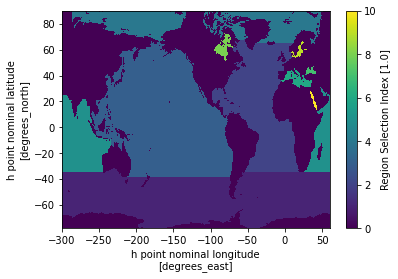

In [93]:
grid.basin.plot()
# use xarray where to grab stuff in particular basin
#where grid geolat > 0 --> gives north atlantic, ( can subset the basins more )

In [94]:
tos_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/tos_mean.nc')
sos_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/sos_mean.nc')
npp_mean = xr.open_dataset('/home/saumyam/data_netcdf_files/Control_Global/MLD_003_mean.nc')

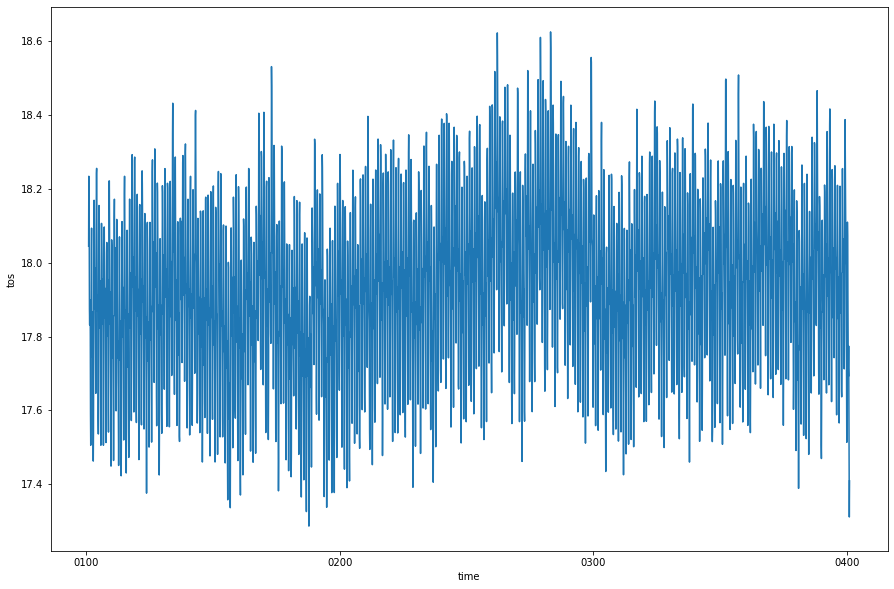

In [95]:
tos_mean['tos'].plot(size=10)

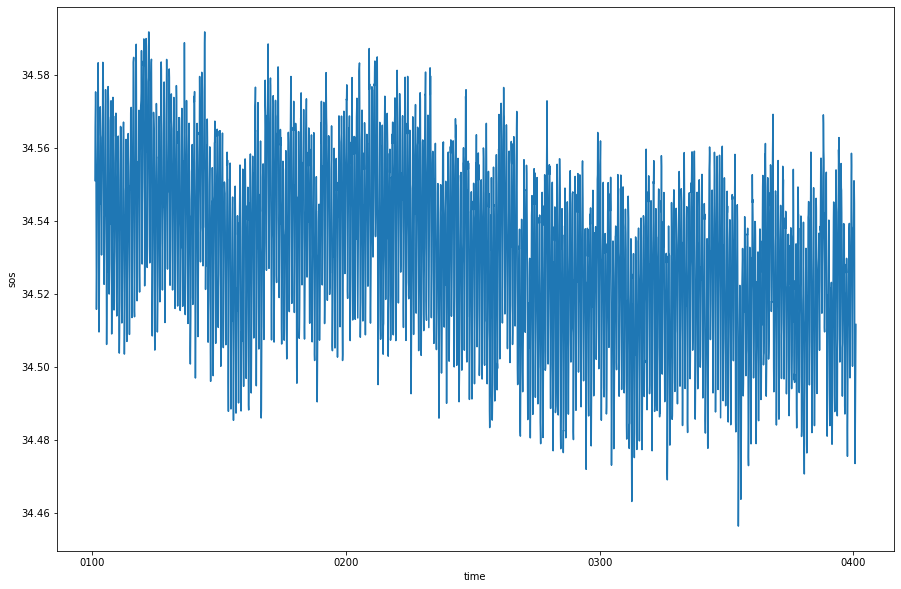

In [116]:
sos_mean['sos'].plot(size=10)

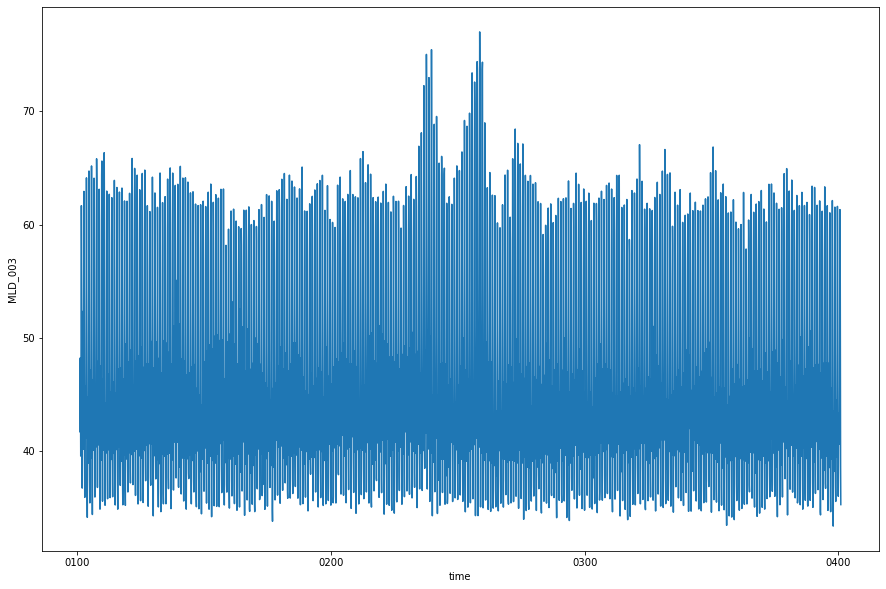

In [117]:
npp_mean['MLD_003'].plot(size=10)

In [96]:
tos_month_means = tos_mean['tos'].groupby('time.month').mean()
tos_month_means['month'==1]

<xarray.DataArray 'tos' ()>
array(18.0401, dtype=float32)
Coordinates:
    month    int64 1

In [97]:
tos_month_var = (tos_mean['tos'].groupby('time.month').std())**2

In [98]:
sos_month_var = (sos_mean['sos'].groupby('time.month').std())**2

In [99]:
npp_month_var = (npp_mean['MLD_003'].groupby('time.month').std())**2

In [100]:
#finds the average across all ensemble members for a particular start year, INCLUDING THE CONTROL
#takes in the start year of the ensemble, driver global means (tos_mean, sos_mean, etc.), and the driver ('tos','sos','MLD_003'
# as parameters

def ensemble_avg(start_year, driver_global, driver):
    
    means = [*range(10)]

    # initialize the sum to be the control
    end = '0' + str(int(start_year) + 9)
    ctrl_slice = driver_global.sel(time=slice(start_year+'-01-16',end+'-12-16'))
    means[0] = ctrl_slice[driver].weighted(grid['areacello']).mean(['xh','yh'])
    total = means[0]
    
    for member in range(1,10):
        folder = 'ESM4_piControl_D-ensemble-' + start_year + '0101-0' + str(member)
        print(folder)
        path = ('/projects/SOCCOM/data/ESM4_PPE/archive/Richard.Slater/xanadu_esm4_20190304_mom6_ESM4_v1.0.3_rc1/' 
                + folder + '/gfdl.ncrc4-intel18-prod-openmp/'+'pp/ocean_month/ts/monthly/5yr/ocean_month.*'+driver+'.nc')
        ds = xr.open_mfdataset(path)
        means[member] = ds[driver].weighted(grid['areacello']).mean(['xh','yh'])
        total = total + means[member]
    avg = total / 10
    return avg, means


In [101]:
def ensemble_stddev(start_year, driver_global, driver):
    
    #first, let's get the average of the ensemble
    avg,means = ensemble_avg(start_year, driver_global, driver)
    
    sum_sqr = (means[0]-avg)**2
    for member in range(1,10):
        sum_sqr = sum_sqr + (means[member] - avg)**2
        
    sum_sqr = sum_sqr / 9
    return sum_sqr


In [102]:
STARTS = ['0123','0161','0185','0208','0230','0269','0300','0326','0359','0381']
def all_ens_stddev(driver_global, driver):
    # initialize total to be stddev of first ensemble - year '0123'
    first = ensemble_stddev(STARTS[0],driver_global,driver)
    timei = first.time
    total = first
    for ens in range(1,10):
        time_adjusted = ensemble_stddev(STARTS[ens],driver_global,driver).assign_coords(time=timei)
        total = total + time_adjusted
    return total/10

ens_stddev = all_ens_stddev(tos_mean,'tos')

ESM4_piControl_D-ensemble-01230101-01
ESM4_piControl_D-ensemble-01230101-02
ESM4_piControl_D-ensemble-01230101-03
ESM4_piControl_D-ensemble-01230101-04
ESM4_piControl_D-ensemble-01230101-05
ESM4_piControl_D-ensemble-01230101-06
ESM4_piControl_D-ensemble-01230101-07
ESM4_piControl_D-ensemble-01230101-08
ESM4_piControl_D-ensemble-01230101-09
ESM4_piControl_D-ensemble-01610101-01
ESM4_piControl_D-ensemble-01610101-02
ESM4_piControl_D-ensemble-01610101-03
ESM4_piControl_D-ensemble-01610101-04
ESM4_piControl_D-ensemble-01610101-05
ESM4_piControl_D-ensemble-01610101-06
ESM4_piControl_D-ensemble-01610101-07
ESM4_piControl_D-ensemble-01610101-08
ESM4_piControl_D-ensemble-01610101-09
ESM4_piControl_D-ensemble-01850101-01
ESM4_piControl_D-ensemble-01850101-02
ESM4_piControl_D-ensemble-01850101-03
ESM4_piControl_D-ensemble-01850101-04
ESM4_piControl_D-ensemble-01850101-05
ESM4_piControl_D-ensemble-01850101-06
ESM4_piControl_D-ensemble-01850101-07
ESM4_piControl_D-ensemble-01850101-08
ESM4_piContr

In [103]:
with ProgressBar():
    ens_std_globalmean = ens_stddev.compute()

[########################################] | 100% Completed | 32.2s


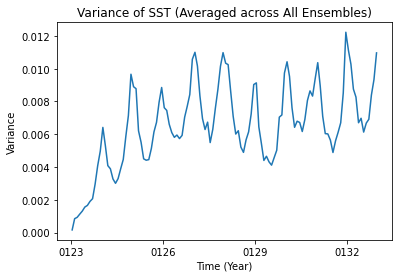

In [104]:
ens_std_globalmean.plot()
plt.title('Variance of SST (Averaged across All Ensembles)')
plt.xlabel('Time (Year)')
plt.ylabel('Variance')
plt.savefig('Variance of SST (Averaged across All Ensembles)')

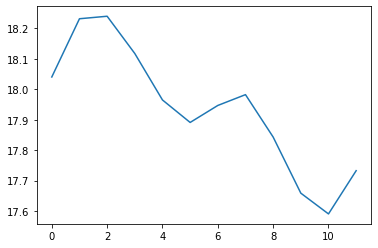

In [105]:
plt.plot(tos_month_means)

In [106]:
def get_ppp(driver_ens_var, month_var):
    ppp = [*range(120)]
    for t in range(120):
        ppp[t] = 1 - (driver_ens_var.isel(time=t) / month_var['month'==t%12])
    return ppp
#check out .repeat() for numpy - consider repeating the control mean 

Text(0, 0.5, 'PPP of SST')

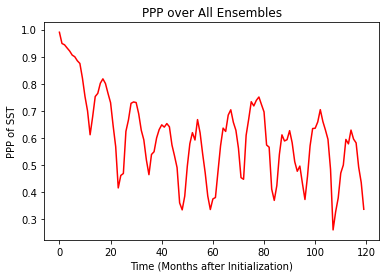

In [107]:
plt.plot(get_ppp(ens_std_globalmean,tos_month_var), color='r',mfc='pink' )
plt.title('PPP over All Ensembles')
plt.xlabel('Time (Months after Initialization)')
plt.ylabel('PPP of SST')
#plt.savefig('PPP of SST, Ensemble Start Year 208')

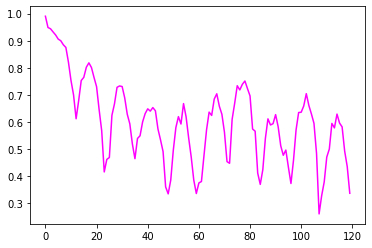

In [108]:
plt.plot(ppp, color='magenta',mfc='pink' )

In [109]:
sos_var = all_ens_stddev(sos_mean,'sos')
with ProgressBar():
    sos_var = sos_var.compute()

ESM4_piControl_D-ensemble-01230101-01
ESM4_piControl_D-ensemble-01230101-02
ESM4_piControl_D-ensemble-01230101-03
ESM4_piControl_D-ensemble-01230101-04
ESM4_piControl_D-ensemble-01230101-05
ESM4_piControl_D-ensemble-01230101-06
ESM4_piControl_D-ensemble-01230101-07
ESM4_piControl_D-ensemble-01230101-08
ESM4_piControl_D-ensemble-01230101-09
ESM4_piControl_D-ensemble-01610101-01
ESM4_piControl_D-ensemble-01610101-02
ESM4_piControl_D-ensemble-01610101-03
ESM4_piControl_D-ensemble-01610101-04
ESM4_piControl_D-ensemble-01610101-05
ESM4_piControl_D-ensemble-01610101-06
ESM4_piControl_D-ensemble-01610101-07
ESM4_piControl_D-ensemble-01610101-08
ESM4_piControl_D-ensemble-01610101-09
ESM4_piControl_D-ensemble-01850101-01
ESM4_piControl_D-ensemble-01850101-02
ESM4_piControl_D-ensemble-01850101-03
ESM4_piControl_D-ensemble-01850101-04
ESM4_piControl_D-ensemble-01850101-05
ESM4_piControl_D-ensemble-01850101-06
ESM4_piControl_D-ensemble-01850101-07
ESM4_piControl_D-ensemble-01850101-08
ESM4_piContr

In [110]:
sos_ppp = get_ppp(sos_var, sos_month_var)

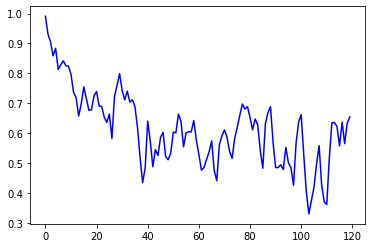

In [111]:
plt.plot(sos_ppp,color='blue')

In [112]:
npp_var = all_ens_stddev(npp_mean,'MLD_003')
with ProgressBar():
    npp_var = npp_var.compute()

ESM4_piControl_D-ensemble-01230101-01
ESM4_piControl_D-ensemble-01230101-02
ESM4_piControl_D-ensemble-01230101-03
ESM4_piControl_D-ensemble-01230101-04
ESM4_piControl_D-ensemble-01230101-05
ESM4_piControl_D-ensemble-01230101-06
ESM4_piControl_D-ensemble-01230101-07
ESM4_piControl_D-ensemble-01230101-08
ESM4_piControl_D-ensemble-01230101-09
ESM4_piControl_D-ensemble-01610101-01
ESM4_piControl_D-ensemble-01610101-02
ESM4_piControl_D-ensemble-01610101-03
ESM4_piControl_D-ensemble-01610101-04
ESM4_piControl_D-ensemble-01610101-05
ESM4_piControl_D-ensemble-01610101-06
ESM4_piControl_D-ensemble-01610101-07
ESM4_piControl_D-ensemble-01610101-08
ESM4_piControl_D-ensemble-01610101-09
ESM4_piControl_D-ensemble-01850101-01
ESM4_piControl_D-ensemble-01850101-02
ESM4_piControl_D-ensemble-01850101-03
ESM4_piControl_D-ensemble-01850101-04
ESM4_piControl_D-ensemble-01850101-05
ESM4_piControl_D-ensemble-01850101-06
ESM4_piControl_D-ensemble-01850101-07
ESM4_piControl_D-ensemble-01850101-08
ESM4_piContr

In [113]:
npp_ppp = get_ppp(npp_var, npp_month_var)

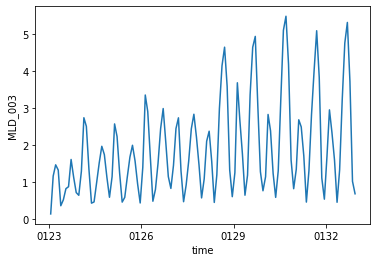

In [119]:
npp_var.plot()

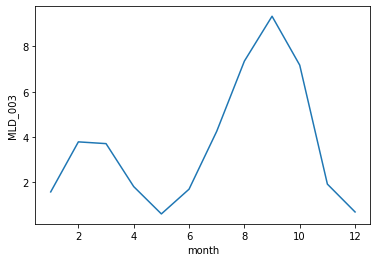

In [118]:
npp_month_var.plot()

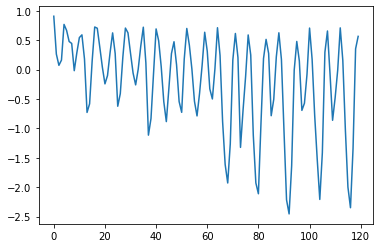

In [114]:
plt.plot(npp_ppp)